![qiskit_header.png](../../images/qiskit_header.png)

## Interleaved Randomized Benchmarking
---

* **Last Updated:** August 19, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.2, qiskit-aer 0.2


## Introduction

**Interleaved Randomized Benchmarking** is a variant of the Randomized Benchmarking (RB) method that is used for benchmarking individual Clifford gates via randomization. The protocol consists of interleaving random gates between the given Clifford gate of interest. The protocol estimates the gate error of the given Clifford. 
The method is based on the paper *"Efficient measurement of quantum gate error by interleaved randomized benchmarking"*(https://arxiv.org/abs/1203.4550).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module in order to perform interleaved RB.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

from qiskit import *

## Select the Parameters of the Interleaved RB Run

First, wee need to choose the regular RB parameters:

- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of Cliffords.

As well as another parameter for interleaved RB:
- **interleaved_gates:** A list of gates of Clifford elements that will be interleaved. The length of the list would equal the length of the rb_pattern.

In this example we have 3 qubits Q0,Q1,Q2. 
We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, 
where there are twice as many 1Q Clifford gates.

In [2]:
#Number of qubits
nQ = 2
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
#rb_pattern = [[0,2],[1]]
rb_pattern = [[0,1]]
#Do three times as many 1Q Cliffords
length_multiplier = [1,3]
#Interleaved Clifford gates (2-qubits and 1-qubit)
interleaved_gates = [['h 0', 'cx 0 1'],['x 0']]

In [13]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
#circ_02.h(qregs_02[0])
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

┌───┐     
q6_0: ┤ H ├──■──
      └───┘┌─┴─┐
q6_1: ─────┤ X ├
           └───┘

In [14]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0])
circ_1.draw()

┌───┐
q7_0: ┤ X ├
      └───┘

## Generate Interleaved RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_original_circs:** A list of lists of circuits for the original RB sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

As well as:
- **rb_interleaved_circs**: A list of lists of circuits for the interleaved RB sequences (separate list for each seed).

In [15]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
rb_opts['interleaved_elem'] = [circ_02, circ_1]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first original and interleaved RB sequences:

In [16]:
#Original RB circuits
print (rb_original_circs[0][0])

      ┌───┐┌───┐┌───┐┌───┐ ░ ┌─────┐┌───┐┌─────┐┌───┐        ┌─┐        
qr_0: ┤ X ├┤ S ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├┤ SDG ├┤ X ├────────┤M├────────
      ├───┤├───┤└─░─┘├───┤ ░ └┬───┬┘└─░─┘└┬───┬┘├───┤┌───┐ ░ └╥┘┌───┐┌─┐
qr_1: ┤ Y ├┤ S ├──░──┤ Y ├────┤ H ├───░───┤ Z ├─┤ H ├┤ S ├─░──╫─┤ Y ├┤M├
      ├───┤├───┤  ░  └───┘ ░ ┌┴───┴┐┌───┐ └┬─┬┘ └───┘└───┘ ░  ║ └───┘└╥┘
qr_2: ┤ Y ├┤ S ├───────────░─┤ SDG ├┤ Y ├──┤M├────────────────╫───────╫─
      └───┘└───┘           ░ └─────┘└───┘  └╥┘                ║       ║ 
cr: 3/══════════════════════════════════════╩═════════════════╩═══════╩═
                                            1                 0       2 


In [17]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

      ┌───┐┌───┐┌───┐┌───┐ ░ ┌───┐                ░              ┌─────┐┌───┐»
qr_0: ┤ X ├┤ S ├┤ H ├┤ S ├─░─┤ H ├───────■────────░───────────■──┤ SDG ├┤ H ├»
      ├───┤├───┤└─░─┘├───┤ ░ └─░─┘┌───┐  │  ┌───┐ ░  ░ ┌───┐  │  └──░──┘├───┤»
qr_1: ┤ Y ├┤ S ├──░──┤ X ├─────░──┤ Y ├──┼──┤ H ├────░─┤ X ├──┼─────░───┤ Z ├»
      ├───┤├───┤  ░  └───┘ ░   ░  └───┘┌─┴─┐└───┘ ░  ░ └───┘┌─┴─┐┌─────┐├───┤»
qr_2: ┤ Y ├┤ S ├───────────░───────────┤ X ├──────░─────────┤ X ├┤ SDG ├┤ Y ├»
      └───┘└───┘           ░           └───┘      ░         └───┘└─────┘└───┘»
cr: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«           ┌─┐                        
«qr_0: ─────┤M├────────────────────────
«      ┌───┐└╥┘┌───┐ ░ ┌───┐ ░ ┌───┐┌─┐
«qr_1: ┤ H ├─╫─┤ S ├─░─┤ X ├─░─┤ Y ├┤M├
«      └┬─┬┘ ║ └───┘ ░ └───┘ ░ └───┘└╥┘
«qr_2: ─┤M├──╫───────────────────────╫─
«       └╥┘  ║                       ║ 
«cr: 3/══

## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [19]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the original and interleaved RB sequences either using a Qiskit Aer Simulator (with some noise model) or using an IBMQ provider, and obtain a list of results, `result_list`.

In [20]:
#Original RB circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
original_result_list = []
original_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_original_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    original_result_list.append(job.result())
    original_qobj_list.append(qobj)    
print("Finished Simulating Original Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Original Circuits


In [21]:
#Interleaved RB circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
#basis_gates = ['sx', 'x', 'cx', 'rz']
shots = 1024
interleaved_result_list = []
interleaved_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_interleaved_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    interleaved_result_list.append(job.result())
    interleaved_qobj_list.append(qobj)    
print("Finished Simulating Interleaved Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Interleaved Circuits


## Fit the results

We fit the results of the original RB circuits and the interleaved RB circuits into an exponentially decaying function and obtain the *Errors per Clifford* $\alpha$ and $\alpha_C$ of the original and interleaved sequences, respectively.

In [22]:
#Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])

### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha_C/\alpha)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

In [23]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])

In [24]:
#Print the joint fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit interleaved RB:', joint_rb_fit.fit_int[patt_ind])

pattern: 0 - 2 qubit interleaved RB: {'alpha': 0.9797902902454094, 'alpha_err': 0.0005506542986954342, 'alpha_c': 0.9678364411833739, 'alpha_c_err': 0.0023913483074601886, 'epc_est': 0.009150311945101158, 'epc_est_err': 0.0018772614534003718, 'systematic_err': 0.021164252686784707, 'systematic_err_L': -0.012013940741683549, 'systematic_err_R': 0.030314564631885865}
pattern: 1 - 1 qubit interleaved RB: {'alpha': 0.9975450455679591, 'alpha_err': 0.00028343210034180075, 'alpha_c': 0.9950023230048344, 'alpha_c_err': 0.0006115190505714393, 'epc_est': 0.001274490096673797, 'epc_est_err': 0.00033768218508659, 'systematic_err': 0.001274490096673797, 'systematic_err_L': 0.0, 'systematic_err_R': 0.002548980193347594}


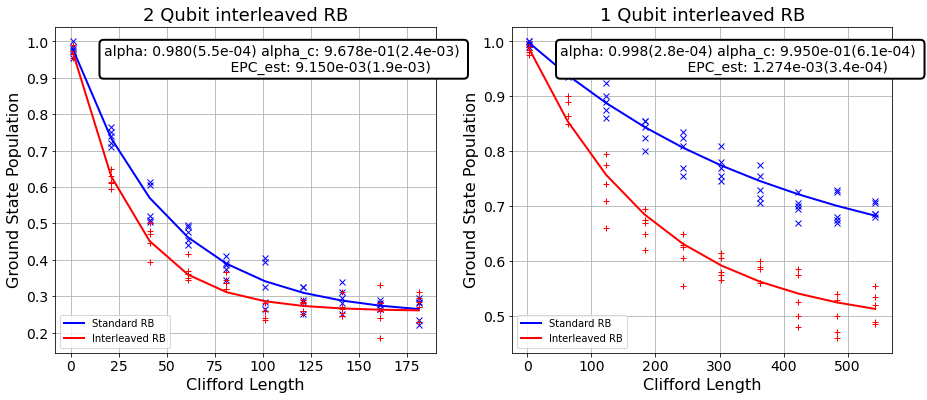

In [25]:
#Plot the joint RB data
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit interleaved RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

In [28]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright